## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

/bin/bash: gdown: command not found


In [2]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

/bin/bash: gdown: command not found


In [3]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

--2024-02-01 00:52:48--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.192.41, 52.217.229.17, 52.216.29.196, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.192.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip           7%[>                   ] 492.92M  2.83MB/s    eta 1h 43m ^C
unzip:  cannot find or open /content/val2014.zip, /content/val2014.zip.zip or /content/val2014.zip.ZIP.
--2024-02-01 01:01:32--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.128.201, 52.216.213.177, 16.182.42.129, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.128.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trai

In [ ]:
!pip install matplotlib pillow

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import nltk
nltk.download('punkt')  # Download the Punkt tokenizer models
import faiss
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample
# print(img)
print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [ ]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [ ]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [ ]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [ ]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [ ]:
# Experiment with different index types and parameters
# index_types = ['IndexFlatL2', 'IndexIVFFlat', 'IndexHNSWFlat']
# index_params = [{'nlist': 100}, {'nlist': 100, 'nprobe': 10}, {'M': 32, 'efConstruction': 40}]

# for index_type, index_param in zip(index_types, index_params):
#     print(f"\nExperimenting with {index_type} index")

#     # Create the Faiss index based on the current type and parameters
#     if index_type == 'IndexFlatL2':
#         index = faiss.IndexFlatL2(image_embeddings.shape[1])
#     elif index_type == 'IndexIVFFlat':
#         quantizer = faiss.IndexFlatL2(image_embeddings.shape[1])
#         index = faiss.IndexIVFFlat(quantizer, image_embeddings.shape[1], **index_param)
#     elif index_type == 'IndexHNSWFlat':
#         index = faiss.IndexHNSWFlat(image_embeddings.shape[1], **index_param)

#     # Add the data to the index
#     index.add(image_embeddings)

#     # Your existing code for computing weighted sum and finding closest caption
#     # ...

#     # Measure the time for nearest neighbor search
#     %timeit -r 3 -n 1 compute_weighted_sum(query_image_idx)

#     # Optionally, measure the time for adding data to the index
#     if index_type != 'IndexFlatL2':
#         %timeit -r 3 -n 1 index.add(image_embeddings)

In [ ]:
# Parameters
k_nearest_neighbors = 5
weights = np.ones(k_nearest_neighbors *5)  # Equal weights for simplicity, you can adjust as needed

# Create FAISS index
index = faiss.IndexFlatL2(image_embeddings.shape[1])
index.add(image_embeddings)

# Function to compute the weighted sum of captions for k-nearest neighbors
def compute_weighted_sum(image_idx):
    _, I = index.search(image_embeddings[image_idx].reshape(1, -1), k_nearest_neighbors+1)


    # Exclude the current image and its associated captions
    I = I[0][1:]



    # Extract captions for nearest images
    nearest_captions = caption_embeddings[I.flatten()]

    # Reshape to (k*5, 512) to represent each set of 5 captions as a single vector
    nearest_captions = nearest_captions.reshape(-1, 512)

    # Compute weighted sum of captions
    weighted_sum_captions = np.average(nearest_captions, axis=0, weights=weights)


    return weighted_sum_captions



# print("Query Vector Shape:", query_vector.shape)


13.2 ms ± 3.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Predicted Caption: A woman is taking a picture with her cellphone.
Reference Captions: ['A woman holding a Hello Kitty phone on her hands.', 'A woman holds up her phone in front of her face.', 'A woman in white shirt holding up a cellphone.', 'A woman checking her cell phone with a hello kitty case.', 'The Asian girl is holding her Miss Kitty phone']
BLEU Score: 0.7697028792679851


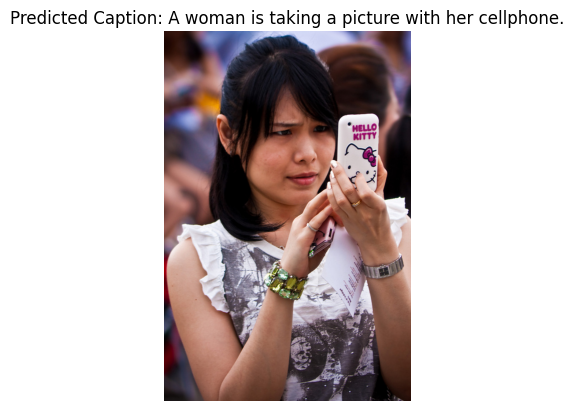

In [ ]:
# Function to find the closest caption index
def find_closest_caption(query_vector):
    distances = np.linalg.norm(caption_embeddings.reshape(-1, 512) - query_vector, axis=1)
    closest_caption_idx = np.argmin(distances)
    return closest_caption_idx


# Load and display the query image using matplotlib
def display_image_with_caption(image_path, caption):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title("Predicted Caption: " + caption)
    plt.axis('off')
    plt.show()

# Example usage
query_image_idx = 100  # Replace with the actual query image index
query_vector = compute_weighted_sum(query_image_idx)
# print(query_vector)

# Find the closest caption index for the given query vector
closest_caption_idx = find_closest_caption(query_vector)

# Retrieve the actual caption from the dataset
predicted_caption = captions_flat[closest_caption_idx]

# Get the reference captions for the query image
reference_captions = captions[query_image_idx]

%timeit -r 3 -n 1 compute_weighted_sum(query_image_idx)


# Compute BLEU score
bleu_score_value = bleu_score.sentence_bleu(reference_captions, predicted_caption)

print("Predicted Caption:", predicted_caption)
print("Reference Captions:", reference_captions)
print("BLEU Score:", bleu_score_value)



# Get the file name of the query image
query_image_id = ids[query_image_idx]
query_image_info = coco_dset.coco.loadImgs(query_image_id)[0]
query_image_path = '/content/val2014/' + query_image_info['file_name']

# query_image_path = img_path[query_image_idx]
display_image_with_caption(query_image_path, predicted_caption)

In [ ]:

def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

predict = ['a cup on a table', 'this music is bad']
real = [['cup placed on a table', 'cup on a table', 'cup on a bench', 'a table', 'a cup'],
        ['this music is bad','this is good music','good music','great songs','singing is great']]
print('accuracy_v2:',accuracy_v2(predict,real))

accuracy_v2: 0.8593041119630842
